In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
from scipy.sparse import csr_matrix

c:\Users\yogit\Desktop\Research Internship\Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your data
data = pd.read_csv('prev.csv')
data = shuffle(data, random_state=42)  # Shuffle the dataset

# Exclude Latitude and Longitude from features used in the model
X = data.drop(columns=['Risk', 'Latitude', 'Longitude'])  # Exclude identifying factors
y = data['Risk']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Length', 'Width', 'Height', 'Area', 'Depth', 'Volume', 'Run out distance']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Type of Material', 'Type of movement', 'Rate of movement', 'Activity', 'Distribution', 'Style', 
                                                         'Failure mechanism', 'Geomorphology', 'Geology', 'Land use/Land cover', 'Hydrological condition', 
                                                         'Triggering Factor', 'Communication', 'Infrastructure', 'Agriculture/Forest/Barren'])
    ])

# Split the shuffled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


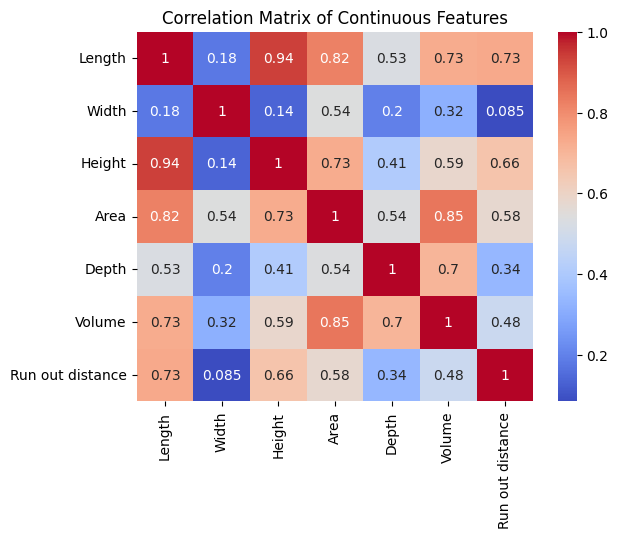

Chi-Square Test for Type of Material: p-value = 0.01795138698075805
Chi-Square Test for Type of movement: p-value = 4.647405194960549e-22
Chi-Square Test for Rate of movement: p-value = 1.5687522066307927e-16
Chi-Square Test for Activity: p-value = 7.350857814979963e-10
Chi-Square Test for Distribution: p-value = 0.0012634242123516798
Chi-Square Test for Style: p-value = 0.000639754778004428
Chi-Square Test for Failure mechanism: p-value = 8.64330454664853e-65
Chi-Square Test for Geomorphology: p-value = 6.832822485297841e-05
Chi-Square Test for Geology: p-value = 1.0
Chi-Square Test for Land use/Land cover: p-value = 1.7286343216220233e-77
Chi-Square Test for Hydrological condition: p-value = 4.613339471637609e-16
Chi-Square Test for Triggering Factor: p-value = 9.450415281976628e-17
Chi-Square Test for Communication: p-value = 2.4085413524544567e-05
Chi-Square Test for Infrastructure: p-value = 0.9265346661594606
Chi-Square Test for Agriculture/Forest/Barren: p-value = 0.973646807015

In [3]:
# Correlation Matrix for continuous features
corr_matrix = X_train[['Length', 'Width', 'Height', 'Area', 'Depth', 'Volume', 'Run out distance']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Continuous Features')
plt.show()

# Chi-Square Test for categorical features
categorical_features = ['Type of Material', 'Type of movement', 'Rate of movement', 'Activity', 'Distribution', 'Style', 
                        'Failure mechanism', 'Geomorphology', 'Geology', 'Land use/Land cover', 'Hydrological condition', 
                        'Triggering Factor', 'Communication', 'Infrastructure', 'Agriculture/Forest/Barren']

for feature in categorical_features:
    contingency_table = pd.crosstab(X_train[feature], y_train)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f'Chi-Square Test for {feature}: p-value = {p}')


In [4]:
# Build the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Extract feature importance
importances = model.named_steps['classifier'].feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                 precision    recall  f1-score   support

           High       0.44      0.40      0.42        10
            Low       0.90      0.93      0.92       157
Low to Moderate       0.00      0.00      0.00         1
       Moderate       0.48      0.43      0.45        28

       accuracy                           0.83       196
      macro avg       0.46      0.44      0.45       196
   weighted avg       0.81      0.83      0.82       196

                                               Feature  Importance
0                                          num__Length    0.065496
5                                          num__Volume    0.063650
3                                            num__Area    0.062410
1                                           num__Width    0.061597
2                                          num__Height    0.057180
..                                                 ...         ...
93   cat__Land use/Land cover_Moderate vegetation, ...    0.000000
113  

c:\Users\yogit\Desktop\Research Internship\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yogit\Desktop\Research Internship\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yogit\Desktop\Research Internship\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

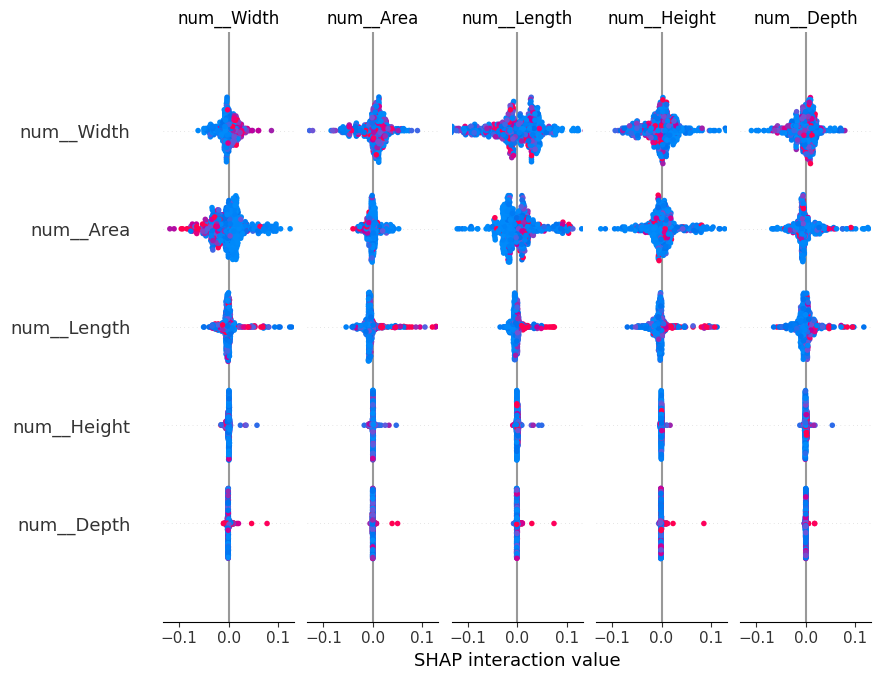

In [5]:
# SHAP Analysis
transformed_X_train = model.named_steps['preprocessor'].transform(X_train)

# Convert the sparse matrix to a dense format if necessary
if isinstance(transformed_X_train, csr_matrix):
    transformed_X_train = pd.DataFrame(transformed_X_train.toarray(), columns=feature_names)
else:
    transformed_X_train = pd.DataFrame(transformed_X_train, columns=feature_names)

# Convert to numeric format, handling any non-numeric values
transformed_X_train = transformed_X_train.apply(pd.to_numeric, errors='coerce')

# Initialize SHAP explainer with the classifier
explainer = shap.TreeExplainer(model.named_steps['classifier'])

# Calculate SHAP values
shap_values = explainer.shap_values(transformed_X_train)

# Check if shap_values is a list (multi-class case)
if isinstance(shap_values, list):
    # Use shap_values for a specific class (e.g., class 1)
    class_index = 1
    shap_values_class = shap_values[class_index]
else:
    # For binary classification or single output
    shap_values_class = shap_values

# Ensure feature_names is the correct length
if transformed_X_train.shape[1] != shap_values_class.shape[1]:
    # Trim shap_values_class to match the number of features
    shap_values_class = shap_values_class[:, :transformed_X_train.shape[1]]

# Plot SHAP summary
shap.summary_plot(shap_values_class, transformed_X_train, feature_names=feature_names)


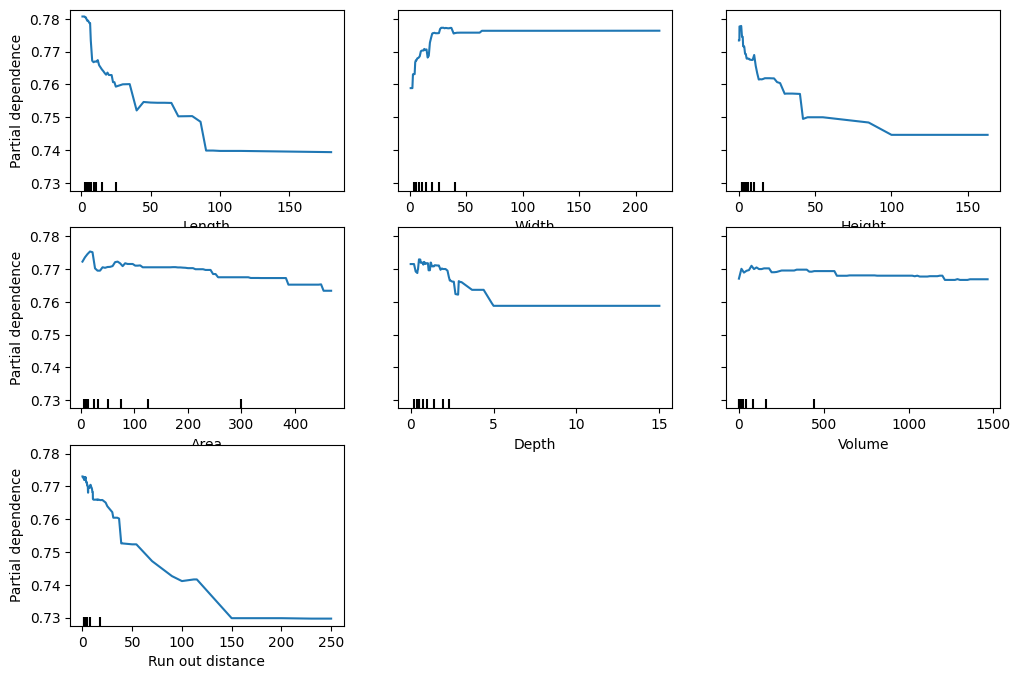

In [6]:
# Convert categorical features to numerical values if needed
data_encoded = pd.get_dummies(data)

# Convert 'Risk' to numerical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data_encoded['Risk'] = le.fit_transform(data['Risk'])

X = data_encoded.drop(columns=['Risk'])
y = data_encoded['Risk']

# Train a Random Forest model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Identify the correct feature names after encoding
encoded_features = X.columns.tolist()

# Update the features list to match the encoded feature names
features = ['Length', 'Width', 'Height', 'Area', 'Depth', 'Volume', 'Run out distance']
# categorical_features = ['Type of Material', 'Type of movement', 'Rate of movement', 'Activity', 'Distribution', 'Style', 
#                         'Failure mechanism', 'Geomorphology', 'Geology', 'Land use/Land cover', 'Hydrological condition', 
#                         'Triggering Factor', 'Communication', 'Infrastructure', 'Agriculture/Forest/Barren']

# Adding dummy feature names for categorical variables
# for feature in categorical_features:
#     dummies = [col for col in encoded_features if col.startswith(feature + '_')]
#     features.extend(dummies)

# Choose a target class for plotting
target_class = 1  # Example: 1 for 'Low'

# Plot Partial Dependence Plots
fig, ax = plt.subplots(figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    features,
    ax=ax,
    target=target_class
)
plt.show()

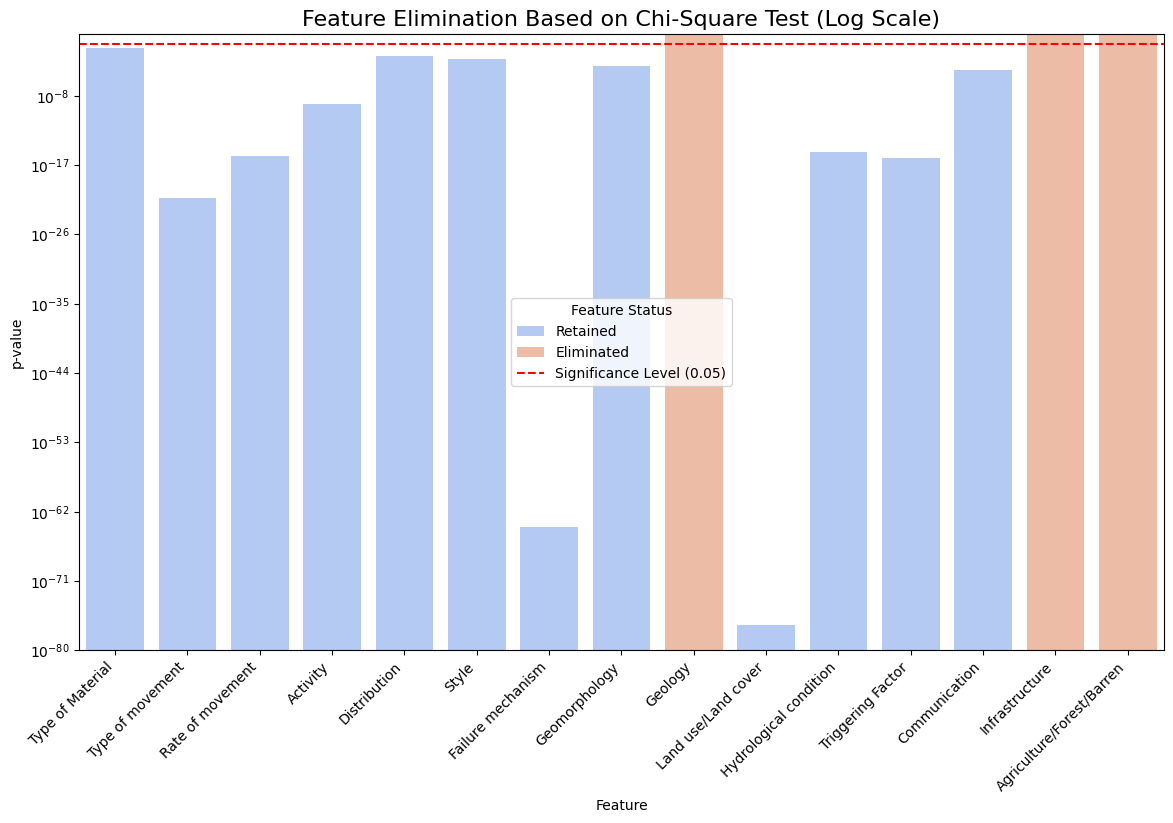

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample Data (Modify as per your DataFrame)
chi_square_df = chi_square_df.copy()  # Ensure it's correctly populated
significance_level = 0.05

# Reverse Status: Retain if p-value > 0.05, Eliminate if p-value <= 0.05
chi_square_df['Status'] = np.where(chi_square_df['p-value'] > significance_level,  'Eliminated', 'Retained')

# Plot the bar chart
plt.figure(figsize=(14, 8))
sns.barplot(data=chi_square_df, x='Feature', y='p-value', hue='Status', dodge=False, palette='coolwarm')

# Add a red dashed line at the significance level (0.05)
plt.axhline(y=significance_level, color='red', linestyle='--', label='Significance Level (0.05)')

# Use a logarithmic scale for the y-axis
plt.yscale('log')

# Set y-axis limits to make smaller p-values visible
plt.ylim(1e-80, 1)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Add title and legend
plt.title('Feature Elimination Based on Chi-Square Test (Log Scale)', fontsize=16)
plt.legend(title='Feature Status')

# Show the plot
plt.show()

